In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# baseline stock to compare our portfolio performance with
BASE_LINE = 'SPY'

# companies stocks in our portfolio
SYMBOLS = ['AAPL', 'XOM', 'IBM', 'PG']

# initial allocations
allocations = np.array([0.3, 0.2, 0.4, 0.1])

# risk free rate, percent return when amount invested in secure asset
risk_free_rate = 0.0

# sampling frequency, currently configured for daily.
# weekly: 52, monthly: 12
sampling_freq = 252

# date range for which we wish to optimize our portfolio
start_date = '2020-09-01'
end_date = '2021-05-31'

# initial investment amount
initial_investment = 100000

In [3]:
def symbol_to_path(symbol, base_dir="data"):
    return os.path.join(base_dir, f"{str(symbol)}.csv")


def get_df(data_frame, symbol, columns, jhow="left"):
    path = symbol_to_path(symbol)
    df_temp = pd.read_csv(path,
                          index_col="Date",
                          parse_dates=True,
                          usecols=columns,
                          na_values=["nan"])
    df_temp = df_temp.rename(columns={columns[1]: symbol})
    data_frame = data_frame.join(df_temp, how=jhow)
    return data_frame


def get_data(symbols, dates):
    data_frame = pd.DataFrame(index=dates)

    if "SPY" in symbols:
        symbols.pop(symbols.index("SPY"))
    data_frame = get_df(data_frame, "SPY", ["Date", "Adj Close"], jhow="inner")

    for s in symbols:
        data_frame = get_df(data_frame, s, ["Date", "Adj Close"])

    return data_frame

def plot_data(df, title="Stock prices"):
    df.plot(figsize=(20, 15), fontsize=15)
    plt.title(title, fontsize=30)
    plt.ylabel("Price [$]", fontsize=20)
    plt.xlabel("Dates", fontsize=20)
    plt.legend(fontsize=20)
    plt.show()


def plot_selected(df, columns, start_date, end_date):
    plt_df = normalize_data(df.loc[start_date:end_date][columns])
    plot_data(plt_df)


def normalize_data(df):
    return df / df.iloc[0, :]

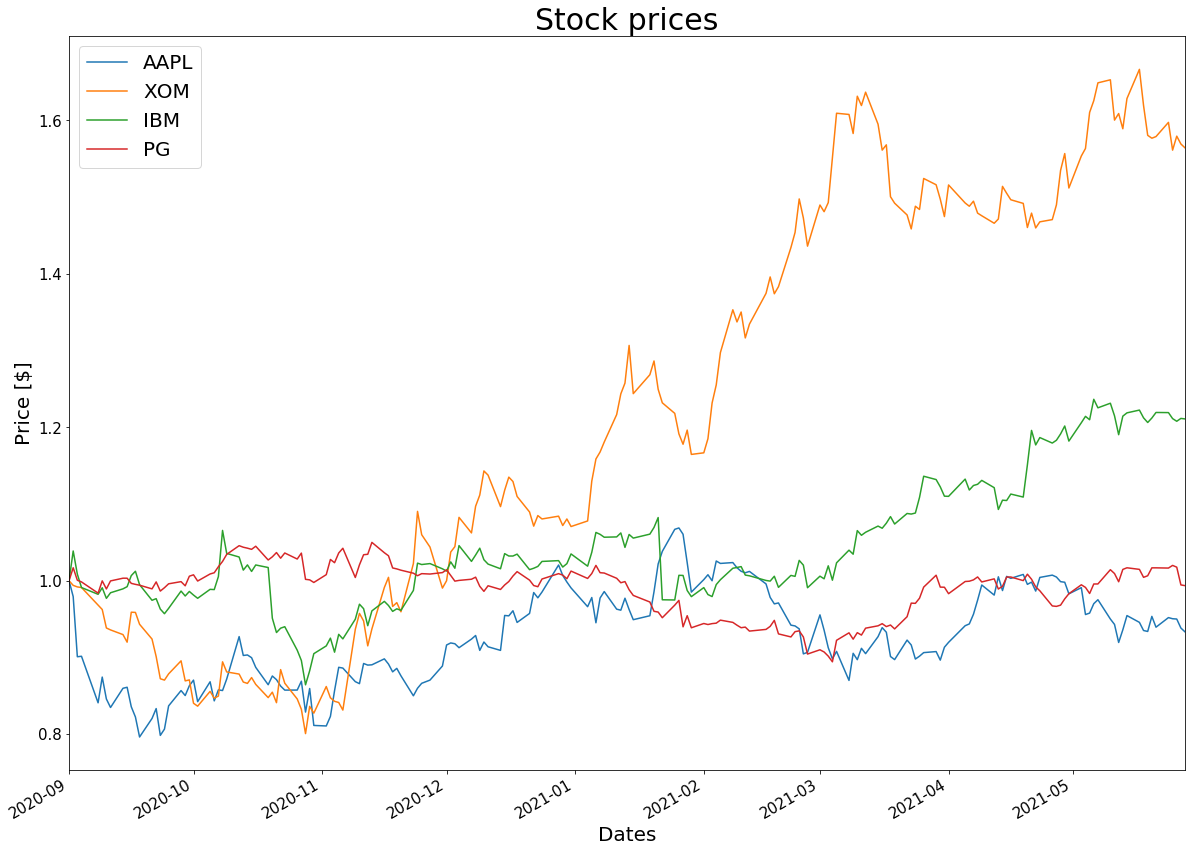

In [4]:
dates = pd.date_range(start_date, end_date)
df = get_data(SYMBOLS, dates)
plot_selected(df, SYMBOLS, start_date, end_date)

In [5]:
price_stocks = df[SYMBOLS]
price_SPY = df[BASE_LINE]

normed_price: pd.DataFrame = price_stocks/price_stocks.values[0]
allocated = normed_price.multiply(normed_price)
position_value = allocated.multiply(initial_investment)
portfolio_value = position_value.sum(axis=1)

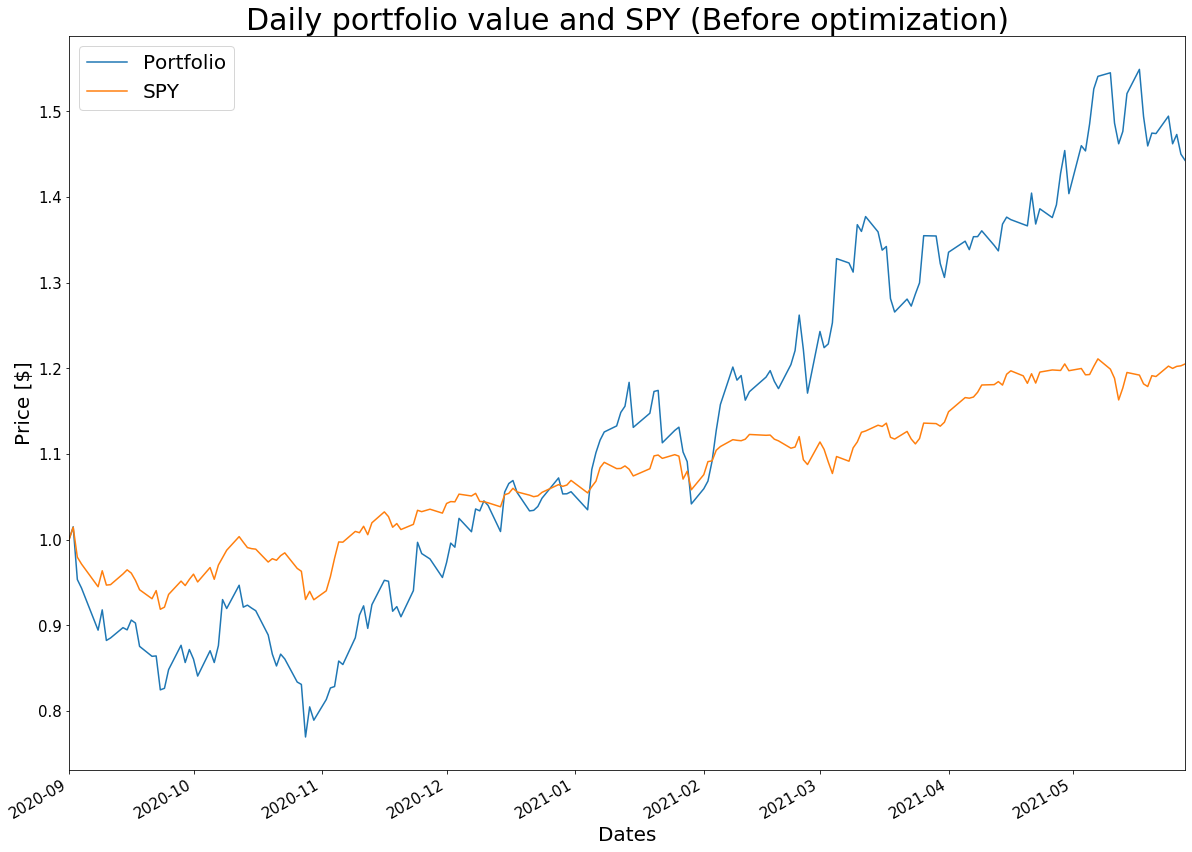

In [6]:
port_val = portfolio_value / portfolio_value[0]
prices_SPY = price_SPY / price_SPY[0]
df_temp = pd.concat([port_val, prices_SPY], keys=['Portfolio', 'SPY'], axis=1)
plot_data(df_temp, title="Daily portfolio value and SPY (Before optimization)")

In [7]:
def compute_daily_returns(df: pd.DataFrame) -> pd.DataFrame:
    daily_returns = df.copy()
    # daily_returns[1:] = (daily_returns[1:] / daily_returns[:-1].values) - 1
    daily_returns = daily_returns / daily_returns.shift(1) - 1
    daily_returns.iloc[0] = 0
    return daily_returns

def compute_sharpe_ratio(sampling_freq: int, risk_free_rate: float, daily_return: pd.DataFrame) -> pd.DataFrame:
    daily_return_std = daily_return.std()
    return np.sqrt(sampling_freq) * ((daily_return.subtract(risk_free_rate)).mean()) / daily_return_std

In [8]:
daily_return = compute_daily_returns(portfolio_value)
sharpe_ratio = compute_sharpe_ratio(sampling_freq, risk_free_rate, daily_return)

print('Sharpe Ratio: ', sharpe_ratio)

Sharpe Ratio:  1.4825803516313996
